In [ ]:
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q Keras==2.1.5 tensorflow==1.13.1

In [ ]:
import pandas as pd
import os
import sys
import glob
import pydicom
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import logging

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Set your project path 
project_path = "/content/drive/My Drive/"
print(project_path)

/content/drive/My Drive/


In [ ]:
# %tensorflow_version 1.x
os.chdir(project_path)
#importing Mask RCNN from matterport
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')


fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
os.chdir(project_path+"Mask_RCNN")
!sudo python3 setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/parallel_model.py to p

In [ ]:
# Import Mask RCNN
sys.path.append(os.path.join(project_path, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

### *Preparing data for MaskRCNN*

In [ ]:
# Returns the list of image path and filenames
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

#Parses the dataset and returns image file names and annotations dictionary
def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps} # contains annotations of the patient
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

* The mask-rcnn library requires that train, validation, and test datasets be managed by a mrcnn.utils.Dataset object.
* This means that a new class must be defined that extends the mrcnn.utils.Dataset class and defines a function to load the dataset, with any name you like such as load_dataset(), and override two functions, one for loading a mask called load_mask() and one for loading an image reference (path or URL) called image_reference().

In [ ]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

#Returns mask and class id
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [ ]:
train_dicom_dir = os.path.join(project_path, 'data/stage_2_train_images')
test_dicom_dir = os.path.join(project_path, 'data/stage_2_test_images')

In [ ]:
# annotations from training dataset
anns = pd.read_csv(os.path.join(project_path, 'data/stage_2_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [ ]:
#Get image file name and annotations dictionary
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [ ]:
print(type(image_fps))
print(image_fps[0])
print(type(image_annotations))
print(image_annotations[image_fps[0]])


<class 'list'>
/content/drive/My Drive/data/stage_2_train_images/3dc305bc-bb28-412d-9932-71f3f49d8905.dcm
<class 'dict'>
[patientId    3dc305bc-bb28-412d-9932-71f3f49d8905
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 4264, dtype: object]


In [ ]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array
image

array([[  0,   1,   3, ...,   3,   3,   3],
       [  0,   1,   3, ...,   3,   3,   3],
       [  0,   1,   3, ...,   3,   3,   3],
       ...,
       [  0,  56,  82, ..., 161, 162, 163],
       [  0,  46,  71, ..., 126, 127, 127],
       [  0,   5,   0, ...,   1,   0,   0]], dtype=uint8)

In [ ]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.26933.1517874474.898998
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.26933.1517874474.898998
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
import random
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

Preparing train and validation test for model building

In [ ]:
# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
image_fps_list = list(image_fps[:10000]) 
# image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
validation_split = 0.1
split_index =int((1 - validation_split) * len(image_fps_list))
print(split_index)
image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))
print(image_fps_val[:6])


9000
9000 1000
['/content/drive/My Drive/data/stage_2_train_images/742640b8-5c3a-4c8c-8296-18f5613758ff.dcm', '/content/drive/My Drive/data/stage_2_train_images/c2974ad2-07ba-4353-9172-1375acd88d9a.dcm', '/content/drive/My Drive/data/stage_2_train_images/5e9ab5d7-c02b-40c1-9b43-bfa862722f82.dcm', '/content/drive/My Drive/data/stage_2_train_images/8077e4fa-9313-4341-bf31-95e26b0065ea.dcm', '/content/drive/My Drive/data/stage_2_train_images/a70e224a-e2da-4263-848e-9da196c834af.dcm', '/content/drive/My Drive/data/stage_2_train_images/81538bc4-5548-4c2a-8ed8-27a32b8eabae.dcm']


In [ ]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [ ]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    cc96c2cc-bcf2-41a3-ae5b-6502be5fb2f7
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 22653, dtype: object]

In [ ]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Let's confirm that the images and masks can be loaded correctly.

(1024, 1024, 3)
(1024, 1024, 2)


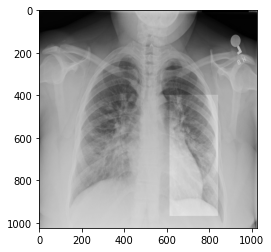

In [ ]:
import cv2
image_id = random.choice(dataset_train.image_ids)
image =  dataset_train.load_image(image_id)
print(image.shape)
mask, class_ids = dataset_train.load_mask(image_id)
print(mask.shape)
plt.imshow(image)
#show mask
plt.imshow(mask[:,:,0],cmap='gray',alpha=0.1)
plt.show()


(1024, 1024, 3)
(1024, 1024, 2)


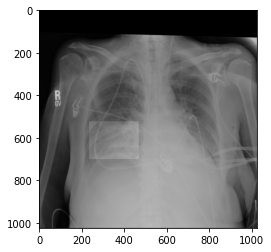

In [ ]:
import cv2
image_id = random.choice(dataset_val.image_ids)
image =  dataset_val.load_image(image_id)
print(image.shape)
mask, class_ids = dataset_val.load_mask(image_id)
print(mask.shape)
plt.imshow(image)
#show mask
plt.imshow(mask[:,:,0],cmap='gray',alpha=0.1)
plt.show()


(1024, 1024, 3)
/content/drive/My Drive/data/stage_2_train_images/37f917c2-68e2-4e03-afed-1d4acf054498.dcm
[0]


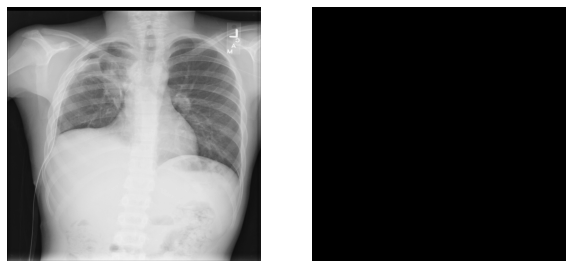

In [ ]:
# Loads and display random samples and their bounding boxes

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

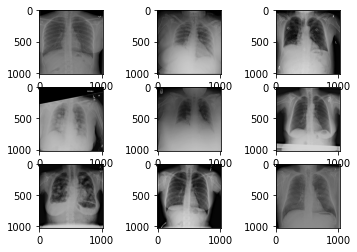

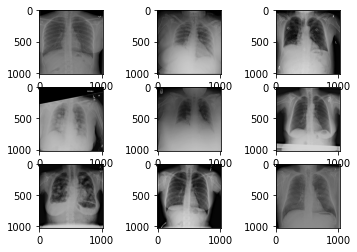

In [ ]:

# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	image = dataset_train.load_image(i)
	plt.imshow(image)
	# plot all masks
	mask, _ = dataset_train.load_mask(i)
	for j in range(mask.shape[2]):
		plt.imshow(mask[:, :, j], cmap='gray', alpha=0.1)
# show the figure
plt.show()
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	image = dataset_train.load_image(i)
	plt.imshow(image)
	# plot all masks
	mask, _ = dataset_train.load_mask(i)
	for j in range(mask.shape[2]):
		plt.imshow(mask[:, :, j], cmap='gray', alpha=0.1)
# show the figure
plt.show()

 Defining the configuration object for the model

In [ ]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Min and max dimension for the image
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    # RPN_ANCHOR_SCALES = (32, 64)
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16 #number of train anchors for a image
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
    STEPS_PER_EPOCH = 100
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

Define the model

In [ ]:
MODEL_DIR = os.path.join(project_path, 'logs')
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
NUM_EPOCHS = 3


# # Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=NUM_EPOCHS, 
#             layers='all')

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=NUM_EPOCHS,
            layers='all',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/logs/pneumonia20200621T0146/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

Evaluating Mask-RCNNmodel

In [ ]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,2.749868,0.335567,1.023467,0.266384,0.596152,0.528280,3.584648,0.580840,1.447398,0.307994,0.657605,0.590792
2,2.502486,0.315949,0.897182,0.206761,0.531689,0.550887,2.684208,0.339395,1.002860,0.229964,0.566143,0.545828
3,2.609105,0.291493,1.025659,0.193504,0.553236,0.545195,2.510415,0.316688,0.902577,0.226802,0.540545,0.523786


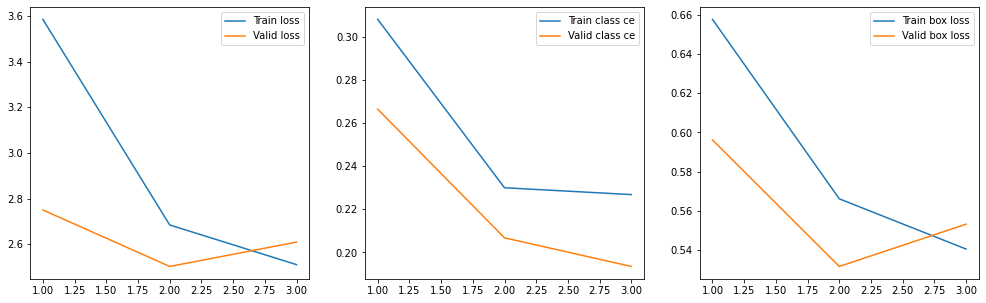

In [ ]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Val class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Val box loss")
plt.legend()

plt.show()

In [ ]:
#Finding the best epoch out of all epochs based on validation loss value
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 2 2.50248571395874


In [ ]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found weight file {}'.format(model_path))

Found model /content/drive/My Drive/logs/pneumonia20200621T0146/mask_rcnn_pneumonia_0002.h5


In [ ]:
INF_DIR =os.path.join(project_path, 'validation')
class InferenceConfig(DetectorConfig):
    NAME = "pneumonia_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=INF_DIR)

# Load trained weights
assert model_path != "", "Trained weights not available in the path"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /content/drive/My Drive/logs/pneumonia20200621T0146/mask_rcnn_pneumonia_0002.h5
Re-starting from epoch 2


### Needs some fix from this step on -- In progress

In [ ]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import asarray
from numpy import expand_dims
from numpy import mean
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [ ]:
# evaluate model on training dataset
train_mAP = evaluate_model(dataset_train, model, inference_config)
print("Train mAP: %.3f" % train_mAP)

Train mAP: nan


In [ ]:
test_image_fps = get_dicom_fps(test_dicom_dir)

In [ ]:
# evaluate model on validation dataset
val_mAP = evaluate_model(dataset_val, model, inference_config)
print("Train mAP: %.3f" % val_mAP)

Train mAP: nan


In [ ]:
results = model.detect([image], verbose=1)
